In [513]:
import numpy as np
import scipy.optimize
import control
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import math
import PIL.Image
plt.style.use('dark_background')

In [529]:
M = 0.350 # kg
G = 9.8 # N/kg
E0 = 0.32722 # J
Vref = 2 * math.pi / (0.11 * 6) # 2 * math.pi / (0.1 * 6)
Pmax = (3.43 / 2) * (Vref / 2) # JX B70 servo max power

K = np.linspace(385 / 2, 385 * 1.5, 20)
Vmax = np.linspace(Vref / 2, Vref * 4, 20) # rad/s

Tstall = Vmax * (Pmax / (Vmax / 2) ** 2)
R = 0.01

6.159985595274104

In [222]:
Xf = np.empty((K.shape[0], Vmax.shape[0], 3))
Xf[:] = np.nan
Z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * K * E0)) / K
for ki, (k, z2_0_) in enumerate(zip(K, Z2_0)):
    for vi, (vmax_, t0) in enumerate(zip(Vmax, Tstall)):
        T0 = 2 * math.pi * math.sqrt(M / k)
        vmax = vmax_ * R
        F0 = t0 / R
        z2_0 = min(z2_0_, F0 / k)
#         if F0 / k < z2_0_:
#         print(F0 / k, z2_0_)
#         print(k * z2_0 ** 2 / 2 - G * M * z2_0)
        Fl_0 = z2_0 * k

        # 
    
        A = np.array([
            # z1', z2, z1
            [0, -k / M, 0], # z1''
            [1, -k * vmax / F0, 0], # z2'
            [1, 0, 0], # z1'
        ])
        B = np.array([-G, -vmax, 0])[...,np.newaxis]
        C = np.eye(3)
        D = np.zeros((3, 1))

        SS = control.StateSpace(A, B, C, D)
        T = np.linspace(0, T0 * 2) # two natural periods to sim the whole thing
        Tout, _, xout = control.forced_response(SS, T, np.ones(T.shape[0]), X0=[0, -z2_0, -z2_0])
    #     [plt.plot(Tout, x) for x in xout]

        if np.any(xout[1] > 0):
            xf = np.nonzero((xout[1, 1:] > 0) ^ (xout[1, :-1] > 0))[0][0]
            x_ = np.dot(A, xout) + B
#             print((x_[2] - x_[1]) / vmax)
#             plt.plot((Tout / T0)[:xf], (xout[2] - xout[1])[:xf]) # ((-k / M * xout[1]))[:xf])
            xfi = lambda l: (l[xf + 1] - l[xf]) * (-xout[1][xf]) / (xout[1][xf + 1] - xout[1][xf]) + l[xf]
            Xf[ki, vi] = [xfi(x) for x in xout]
#             xi = lambda j: lambda t: np.interp(t, Tout, xout[j])
#             tf = scipy.optimize.fsolve(xi(1), T0 / 3)
#             Vf[ki, vi] = xi(0)(tf)
#         break
#     break

<ipython-input-212-1834de088693>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Vmax, K, (Xf[:,:,2] - Xf[:,:,1])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X =
<ipython-input-212-1834de088693>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Vmax, K, DE) # Y = spring constants, X =


Text(0.5, 1.0, 'Single-jump energy gain (E0 = 0.33J, R=0.040m, M=0.350kg)')

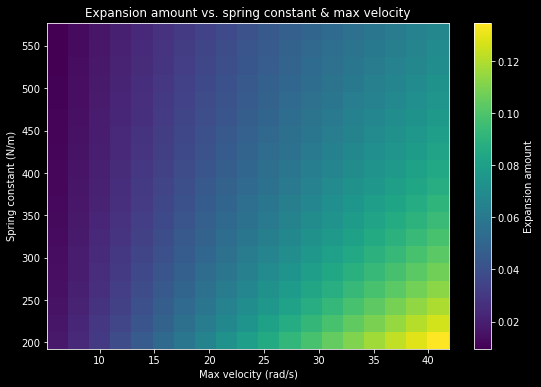

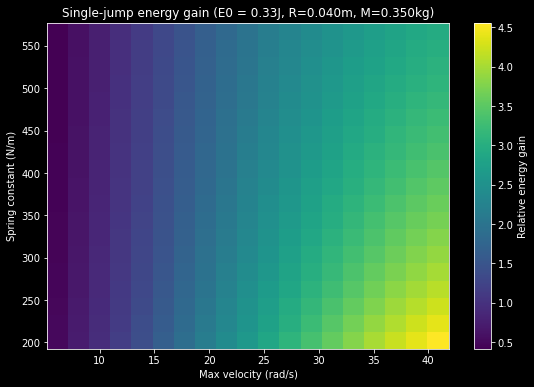

In [212]:
DE = (M * (Xf[:,:,0] ** 2 / 2 + Xf[:,:,2] * G) - E0) / E0
plt.figure(figsize=(9,6))
plt.pcolor(Vmax, K, (Xf[:,:,2] - Xf[:,:,1])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
plt.colorbar(label='Expansion amount')
plt.title('Expansion amount vs. spring constant & max velocity')

plt.figure(figsize=(9,6))
plt.pcolor(Vmax, K, DE) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
plt.colorbar(label='Relative energy gain')
plt.title('Single-jump energy gain (E0 = %.2fJ, R=%.3fm, M=%.3fkg)' % (E0, R, M))

In [526]:
R1, R2, W = (0.04, 0.0254, 0.04)
def nl_ode(k, vmax, tau_stall, d_ = True):
    def nl_ode_(x):
        t1, z1, dz1 = x
        # derived parameters
        t2_arg = (W - R1 * np.cos(t1)) / R2
        t2 = np.arccos(np.minimum(t2_arg, 1))
        phi = t2 + (math.pi - t1)
        z2 = z1 - (R1 * np.sin(t1) + R2 * np.sin(t2))

        Fsp = -k * z2
        
        # Fj = Fsp
        # Fj = tau_1 / R1 * (math.cos(t1) - math.cos(t2) * math.sin(phi))
        # =>
        tau_1 = Fsp * R1 / (np.cos(t1) - np.cos(t2) * np.sin(phi))
        # ---
        # tau_1 = tau_stall * (1 - dt1 / vmax)
        # =>
        dt1 = (1 - tau_1 / tau_stall) * vmax
        if dt1.size > 1:
            dt1[t2_arg >= 1] = 0
        elif t2_arg >= 1:
            dt1 = 0

        # solving for derivatives
        if d_:
            return [
                dt1, # dt1
                dz1, # dz1
                Fsp / M - G # ddz1
            ]
        else:
            return [phi, t1, dt1, tau_1, Fsp, t2, z1, dz1, z2]
    
    return lambda _, x: nl_ode_(x)

    # IGNORE:
#     tau_2 = math.sin(phi) * tau_1 * R2 / R1
#     dz1 = dz2 + (dt1 * R1 * math.cos(t1) + dt2 * R2 * math.cos(t2))
#     ddz1 = ddz2 + (
#         ddt1 * R1 * math.cos(t1) - (dt1 ** 2) * R1 * math.cos(t1) * math.sin(t1)
#         + ddt2 * R2 * math.cos(t2) - (dt2 ** 2) * R2 * math.cos(t2) * math.sin(t2)
#     )

In [530]:
# k = 385
# T0 = 2 * math.pi * math.sqrt(M / k)
# z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * k * E0)) / k
# tstall = Vref * (Pmax / (Vref / 2) ** 2)

K = np.linspace(385 / 2, 385 * 2, 15)
Vmax = np.linspace(Vref / 2, Vref * 2, 15) # rad/s
Tstall = Vmax * (Pmax / (Vmax / 2) ** 2)
E0 = np.linspace(0.2, 1.0, 10)

Xf = np.empty((E0.shape[0], K.shape[0], Vmax.shape[0], 9))
Xf[:] = np.nan
Ef = np.empty((E0.shape[0], K.shape[0], Vmax.shape[0]))
Ef[:] = np.nan
for ei, e0 in enumerate(E0):
    Z2_0 = (G * M + np.sqrt((G * M) ** 2 + 2 * K * e0)) / K
    for ki, (k, z2_0) in enumerate(zip(K, Z2_0)):
        for vi, (vmax, tstall) in enumerate(zip(Vmax, Tstall)):
            T0 = 2 * math.pi * math.sqrt(M / k)
            f_stop = lambda t, x: nl_ode(k, vmax, tstall, False)(0, x)[-1] # extract z2
            f_stop.terminal = True
            dz1_z2_0 = R2 # A HACK: the proper way is to calculate z1 given t0, R1, R2 and W, but it's just too much of a pain atm. FIXME
            sol = scipy.integrate.solve_ivp(nl_ode(k, vmax, tstall), (0, T0 * 2), [0, -z2_0 + dz1_z2_0, 0], rtol=1E-5, events=f_stop)
            params = nl_ode(k, vmax, tstall, False)(0, sol.y)
            [phi, t1, dt1, tau_1, Fsp, t2, z1, dz1, z2] = params
            Em = dz1 ** 2 * M / 2 + (z1 - dz1_z2_0) * G * M
            Xf[ei, ki, vi] = np.array(params)[:,-1] # sol.y[:,-1]
            Ef[ei, ki, vi] = Em[-1]
        
#         plt.figure(1)
#         plt.plot(sol.t, z1 - z2)
#         plt.figure(3)
#         plt.plot(sol.t, t1)
#         plt.figure(2)
#         plt.plot(sol.t, dz1)

# plt.figure(1)
# plt.xlabel('Time')
# plt.ylabel('Piston width')

In [533]:
# plt.ioff()
Ediff = Ef / E0[:, np.newaxis, np.newaxis]
for ei, (ediff, e0) in enumerate(zip(Ediff, E0)):
#     plt.figure(figsize=(9,6))
#     plt.pcolor(Vmax, K, (Xf[:,:,6] - Xf[:,:,8])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
#     plt.ylabel('Spring constant (N/m)')
#     plt.xlabel('Max velocity (rad/s)')
#     plt.colorbar(label='Final piston width (m)')
#     plt.title('Final piston width vs. spring constant & max velocity (E0=%.3f)' % e0)

    fig = plt.figure(figsize=(9,6))
    plt.pcolor(Vmax, K, ediff) # , vmin=np.amin(Ediff), vmax=np.amax(Ediff)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
    plt.ylabel('Spring constant (N/m)')
    plt.xlabel('Max velocity (rad/s)')
    plt.colorbar(label='Relative energy gain') # , mappable=cm.ScalarMappable(norm=colors.Normalize(np.amin(Ediff), np.amax(Ediff)), cmap=cm.get_cmap('viridis')))
    plt.title('Relative energy gain vs. spring constant & max velocity (E0=%.3f)' % e0)
    plt.savefig('/Users/derek-lam/dev/robots/pendbot/proc/energetics/%d.png' % ei)
    plt.close(fig)

# plt.ion()

<ipython-input-533-ff7272d0c5ef>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(Vmax, K, ediff) # , vmin=np.amin(Ediff), vmax=np.amax(Ediff)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X =


Text(0.5, 1.0, 'Expansion amount vs. spring constant & max velocity')

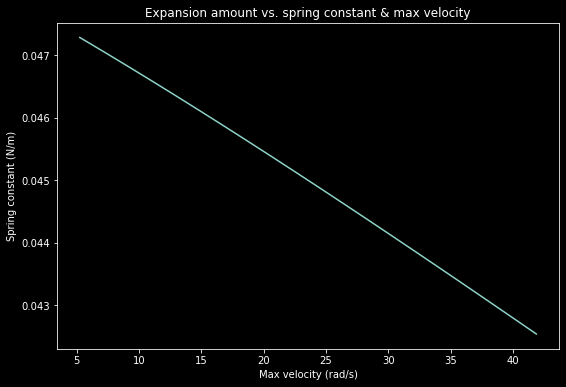

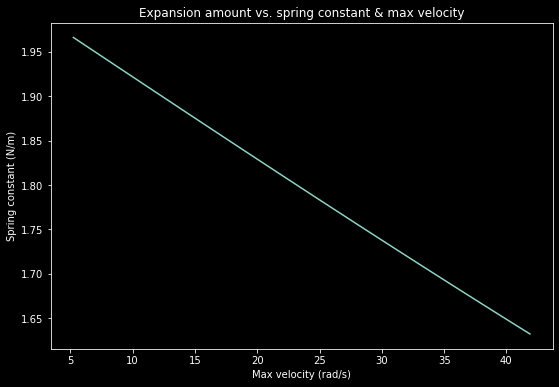

In [440]:
plt.figure(figsize=(9,6))
plt.plot(Vmax, np.squeeze(Xf[:,:,6] - Xf[:,:,8])) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
# plt.colorbar(label='Expansion amount')
plt.title('Expansion amount vs. spring constant & max velocity')

plt.figure(figsize=(9,6))
plt.plot(Vmax, np.squeeze(Ef / E0)) # / Z2_0[:,np.newaxis]) # Y = spring constants, X = 
plt.ylabel('Spring constant (N/m)')
plt.xlabel('Max velocity (rad/s)')
# plt.colorbar(label='Expansion amount')
plt.title('Expansion amount vs. spring constant & max velocity')

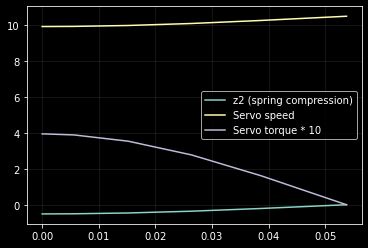

In [399]:
plt.plot(sol.t, z2 * 10)
plt.plot(sol.t, dt1)
plt.plot(sol.t, tau_1 * 10)
plt.legend(['z2 (spring compression)', 'Servo speed', 'Servo torque * 10'])
plt.grid(True, alpha=0.1)